In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Image Acquistion**

In [3]:
# Load Dataset
file_path = '/content/drive/MyDrive/Image_processing_project/A_Z _Handwritten_Data.csv'
data = pd.read_csv(file_path)

In [4]:
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.shape

(372450, 785)

In [6]:
# Separating the labels and features
labels = data.iloc[:, 0].values
features = data.iloc[:, 1:].values

# Normalizing pixel values to range [0, 1]
features = features / 255.0

# Reshaping 28x28 images
images = features.reshape(-1, 28, 28)
print(f"Features reshaped to: {images.shape}")

Features reshaped to: (372450, 28, 28)


Number of unique classes: 26
Class Distribution:
0     13869
1      8668
2     23409
3     10134
4     11440
5      1163
6      5762
7      7218
8      1120
9      8493
10     5603
11    11586
12    12336
13    19010
14    57825
15    19341
16     5812
17    11566
18    48419
19    22495
20    29008
21     4182
22    10784
23     6272
24    10859
25     6076
Name: count, dtype: int64


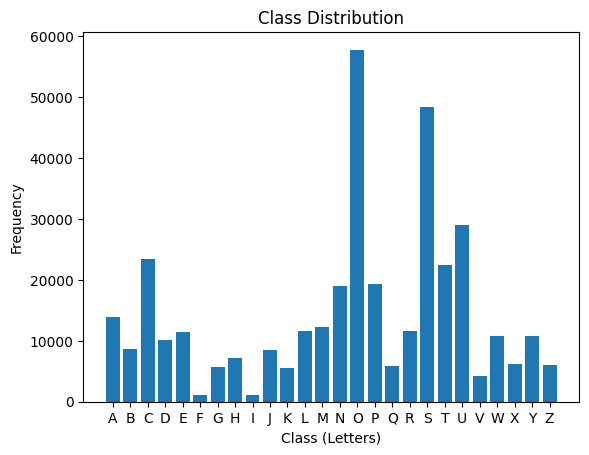

In [7]:
# Unique classes Identification
unique_classes = np.unique(labels)
print(f"Number of unique classes: {len(unique_classes)}")

# Class distribution
class_distribution = pd.Series(labels).value_counts().sort_index()
print("Class Distribution:")
print(class_distribution)


plt.bar(unique_classes, class_distribution)
plt.xticks(unique_classes, [chr(65 + i) for i in unique_classes])
plt.xlabel('Class (Letters)')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

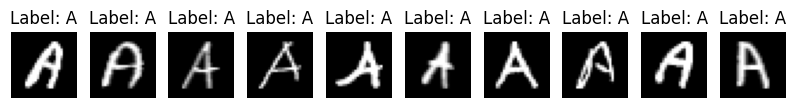

In [8]:
label_map = {i: chr(65 + i) for i in range(26)}
def display_images(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {label_map[labels[i]]}")
        plt.axis('off')
    plt.show()

display_images(images, labels)

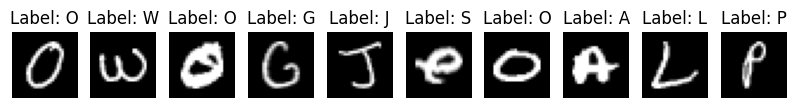

In [9]:
def display_random_images(images, labels, label_map, num_samples=10):
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {label_map[labels[idx]]}")
        plt.axis('off')
    plt.show()


display_random_images(images, labels, label_map)

# **Image Enhancement**

In [10]:
def enhance_image(img):
    img_eq = cv2.equalizeHist((img * 255).astype(np.uint8))
    kernel = np.ones((3, 3), np.uint8)
    img_morph = cv2.morphologyEx(img_eq, cv2.MORPH_CLOSE, kernel)
    img_sharp = cv2.filter2D(img_morph, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return img_eq, img_morph, img_sharp

In [17]:
# Apply enhancement
enhanced_images = []
img_morph_list = []
img_sharp_list = []
for img in images:
    img_eq, img_morph, img_sharp = enhance_image(img)
    enhanced_images.append(img_sharp)
    img_morph_list.append(img_morph)
    img_sharp_list.append(img_sharp)

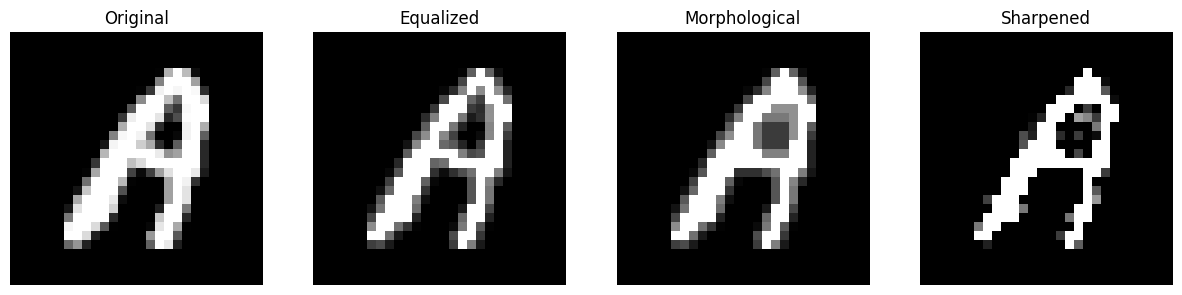

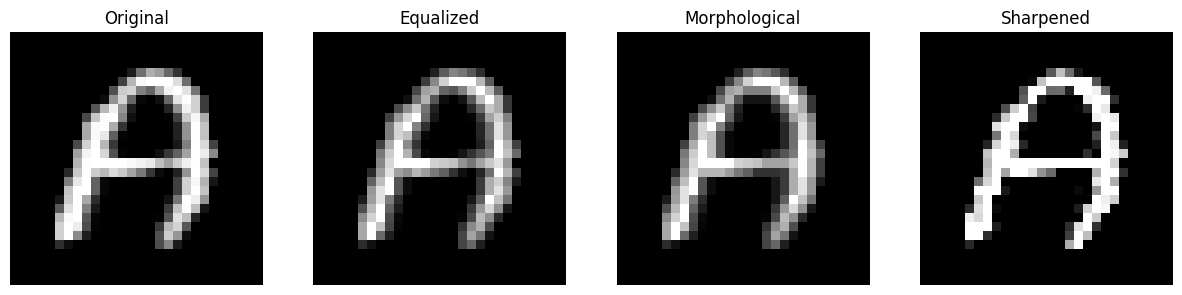

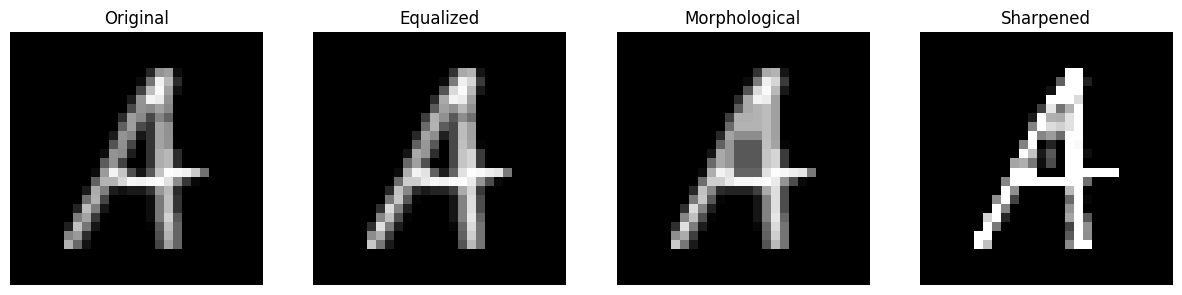

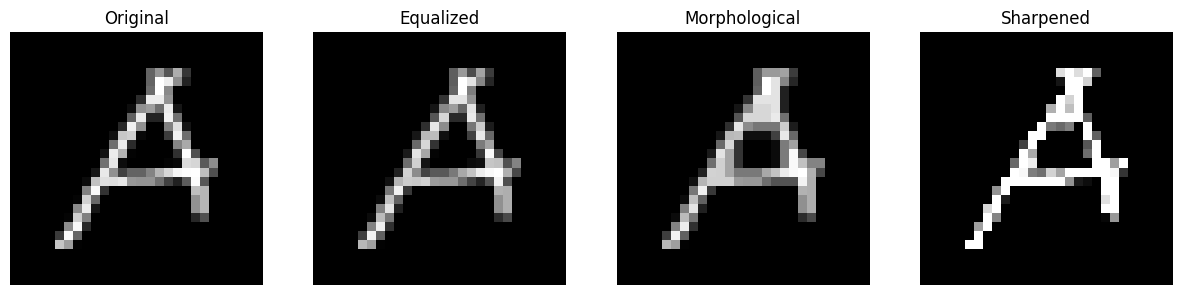

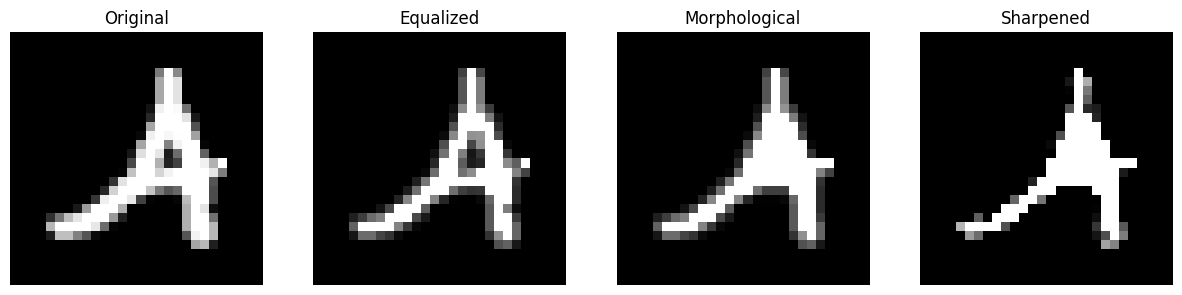

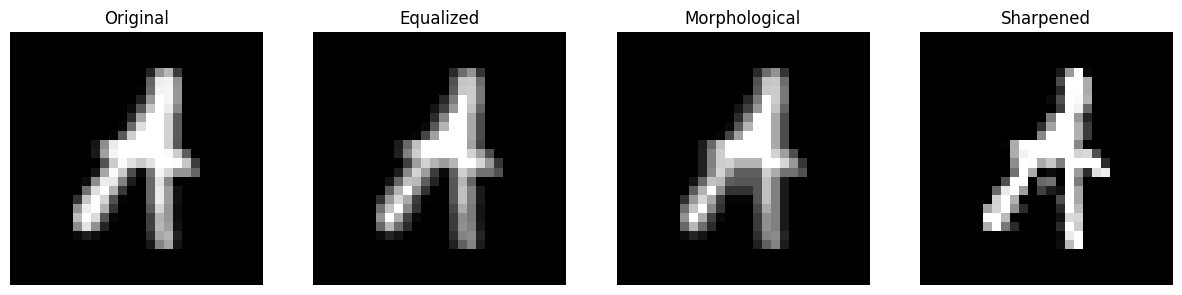

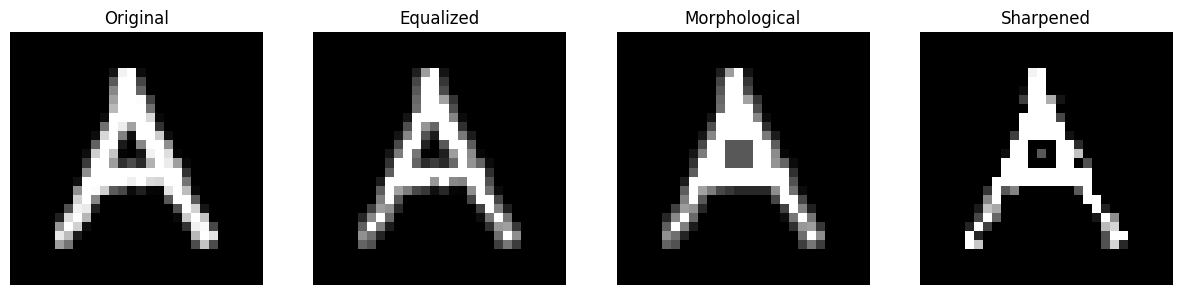

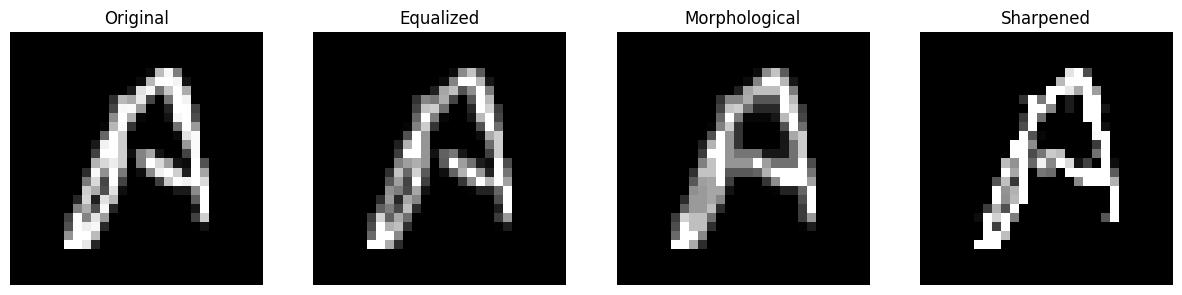

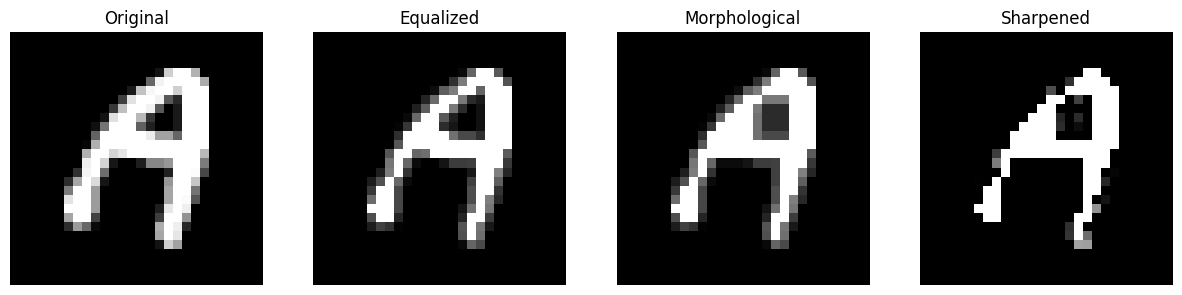

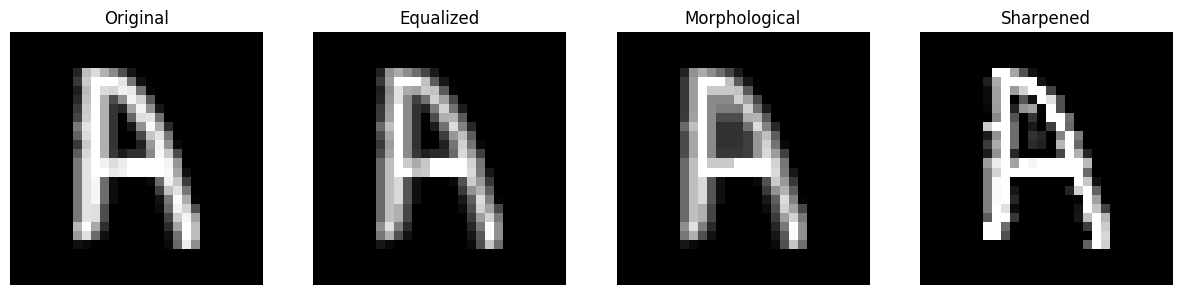

In [21]:
def display_enhanced_images_pipeline(images, num_samples=10):
    for i in range(num_samples):
        img_eq, img_morph, img_sharp = enhance_image(images[i])
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(img_eq, cmap='gray')
        plt.title("Equalized")
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.imshow(img_morph, cmap='gray')
        plt.title("Morphological")
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.imshow(img_sharp, cmap='gray')
        plt.title("Sharpened")
        plt.axis('off')
        plt.show()

display_enhanced_images_pipeline(images)

# **Image Restoration**

In [22]:
def restore_image(img):
    img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    img_denoised = cv2.GaussianBlur(img_bilateral, (5, 5), 0)
    img_median = cv2.medianBlur(img_denoised, 5)
    img_binarized = cv2.adaptiveThreshold(
        img_median, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return img_bilateral, img_denoised, img_median, img_binarized

In [23]:
restored_images = []
for img in enhanced_images:
    _, _, _, img_binarized = restore_image(img)
    restored_images.append(img_binarized)

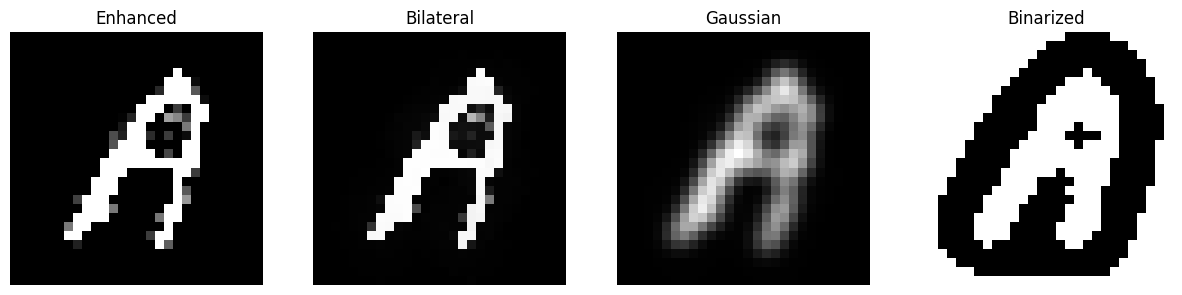

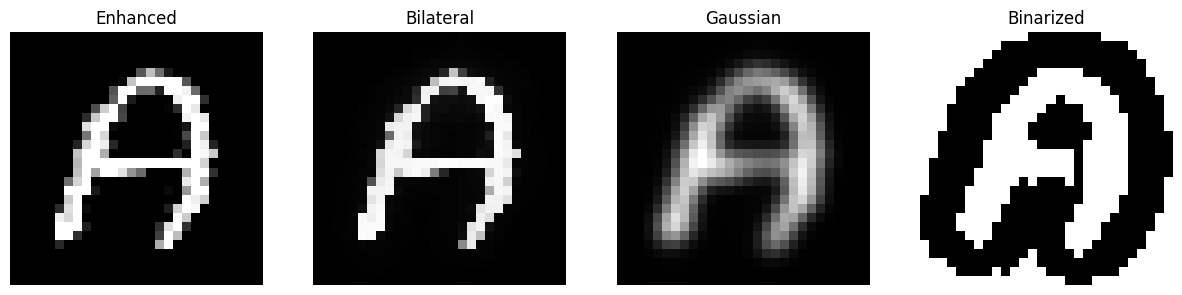

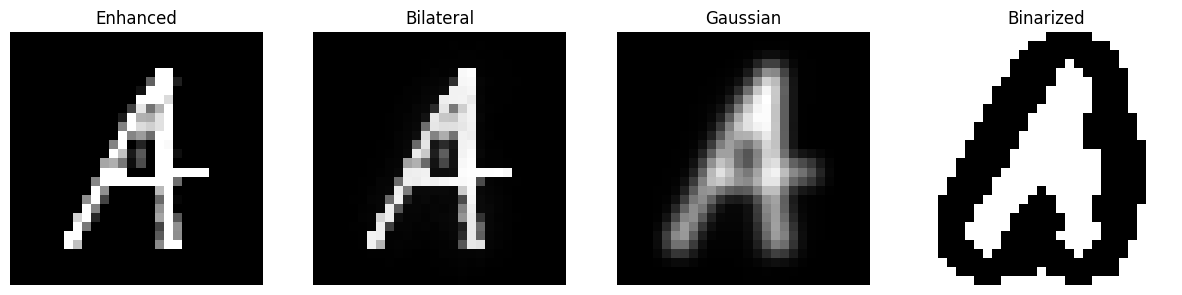

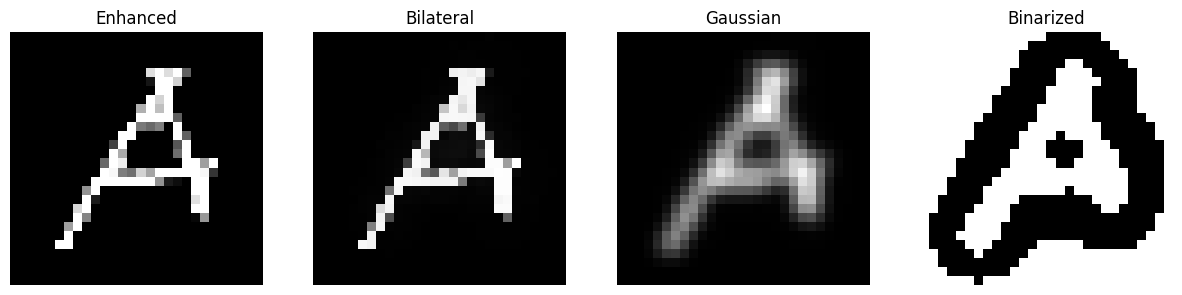

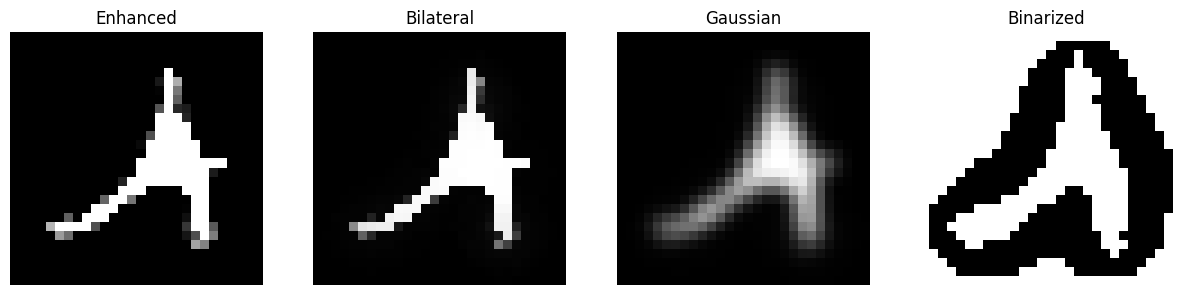

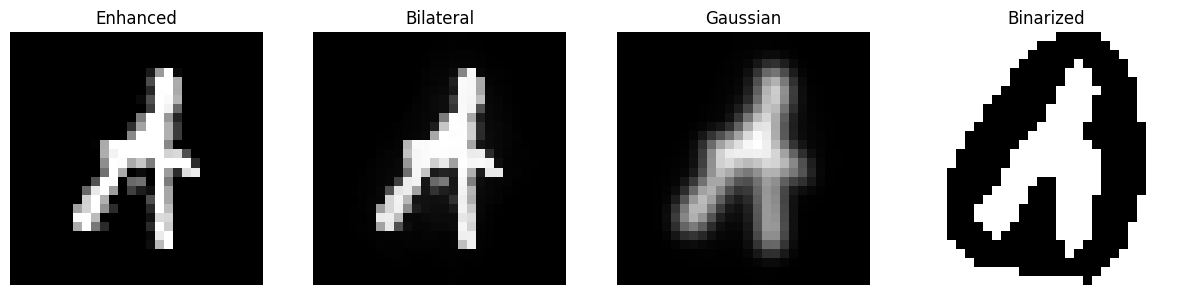

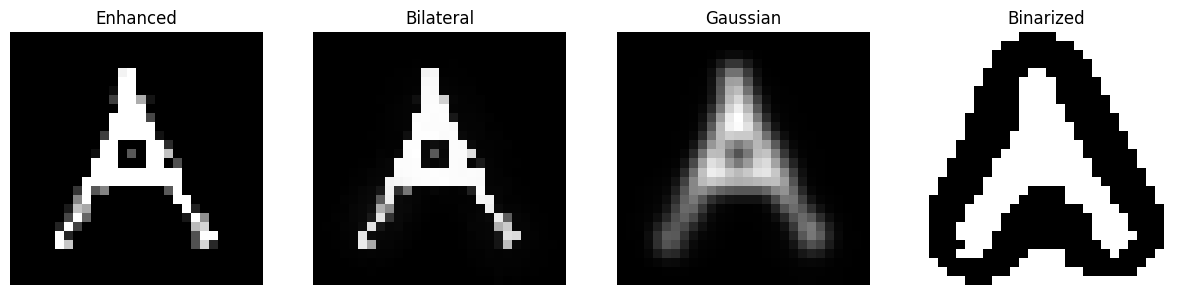

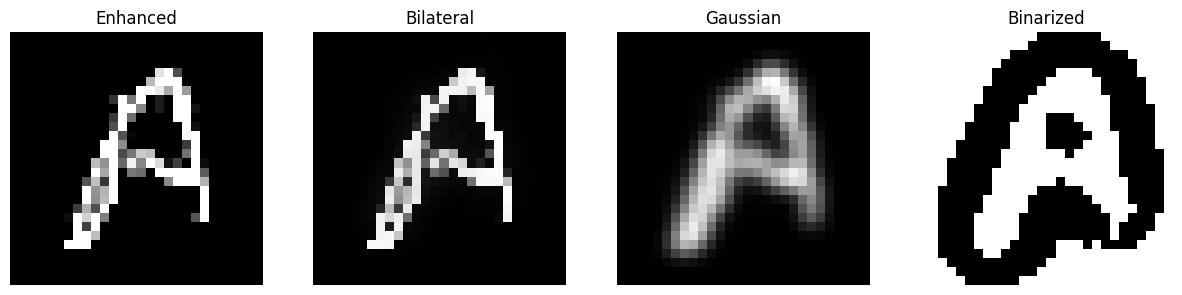

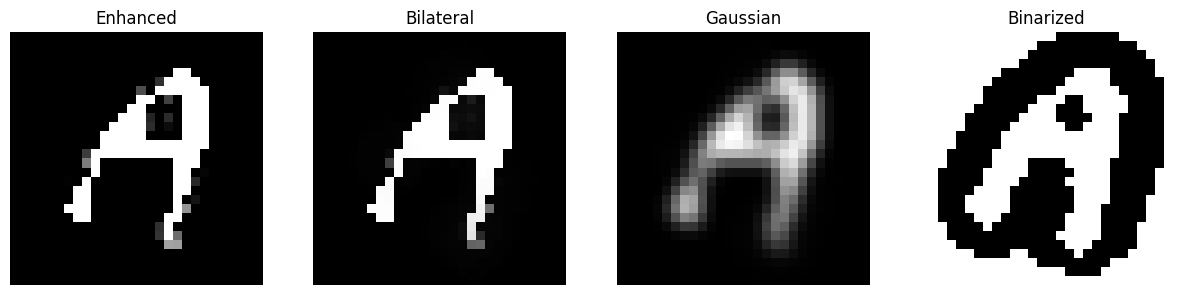

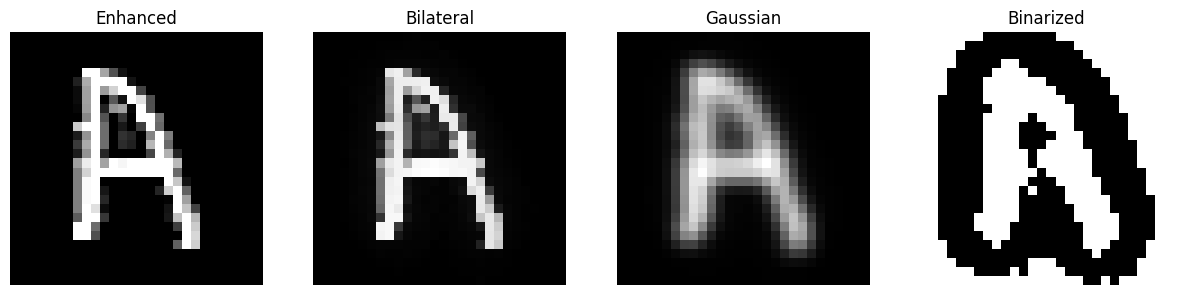

In [24]:
def display_restored_images_pipeline(images, num_samples=10):
    for i in range(num_samples):
        img_bilateral, img_denoised, img_median, img_binarized = restore_image(images[i])
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Enhanced")
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(img_bilateral, cmap='gray')
        plt.title("Bilateral")
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.imshow(img_denoised, cmap='gray')
        plt.title("Gaussian")
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.imshow(img_binarized, cmap='gray')
        plt.title("Binarized")
        plt.axis('off')
        plt.show()

display_restored_images_pipeline(enhanced_images)

# **Image Segmintation**

In [28]:
def segment_characters(img):
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    character_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > 10:
            char_img = binary[y:y + h, x:x + w]
            resized = cv2.resize(char_img, (28, 28))
            character_images.append((resized, x))
    character_images = sorted(character_images, key=lambda item: item[1])
    return binary, [char[0] for char in character_images]


In [30]:
segmented_images = []
for img in restored_images:
    _, segments = segment_characters(img)
    segmented_images.extend(segments)


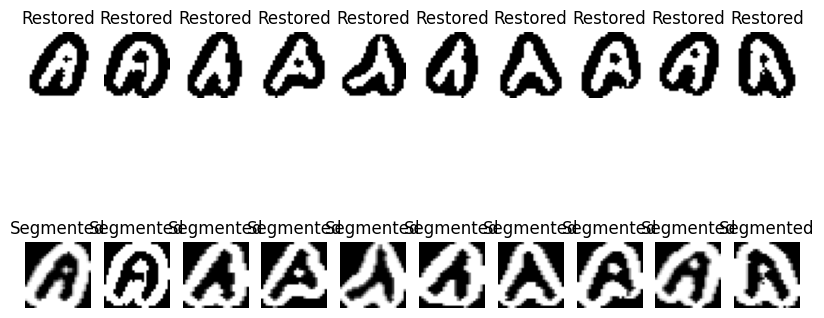

In [31]:
def display_segmented_images(original, segments, num_samples=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title("Restored")
        plt.axis('off')
        if i < len(segments):
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(segments[i], cmap='gray')
            plt.title("Segmented")
            plt.axis('off')
    plt.show()

display_segmented_images(restored_images, segmented_images)


# **Feature Extraztion Using HOG**

In [38]:
def extract_hog_features_with_arrays(images):
    features = []
    for img in images:
        feature, _ = hog(
            img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
            block_norm='L2-Hys', visualize=True
        )
        features.append(feature)
    return np.array(features)

In [39]:
def display_hog_features_as_arrays(images, features, num_samples=5):
    for i in range(num_samples):
        print(f"Original Segment {i + 1}:")
        print(np.array(images[i]), "\n")

        print(f"HOG Features {i + 1}:")
        print(features[i], "\n")
        print("-" * 50)

# Extract HOG features
hog_features = extract_hog_features_with_arrays(segmented_images)

# Display original images and their HOG features as arrays
display_hog_features_as_arrays(segmented_images, hog_features, num_samples=5)


Original Segment 1:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 255 255
  255 255 255  77   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 134 241 246 255 255
  255 255 255 245 241 125   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 153 245 255 255 255 255
  255 255 255 255 255 244 145   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 171 244 255 255 255 255 255
  255 255 255 255 255 255 243 163   0   0]
 [  0   0   0   0   0   0   0   0   0   0 187 245 255 255 255 255 255 228
   45 236 255 255 255 255 255 186   0   0]
 [  0   0   0   0   0   0   0   0  18 201 249 255 255 255 255 185  50  44
    1  46 215 255 255 255 255 241 172   0]
 [  0   0   0   0   0   0   0  38 201 254 255 255 255 255 167  39   0   0
    0   0  48 195 255 255 255 255 214   0]
 [  0   0   0   0   0   0  57 200 255 255 255 255 255 152  38   0   0   0
    0   0   0  48 178 255 255 255 214   0]
 [  0   0   0   0   0   0  77 255 255 255 25

# **Model**


In [43]:
# Align labels with features
if len(features) != len(labels):
    print(f"Mismatch detected: Features={len(features)}, Labels={len(labels)}")
    # Adjust features to match labels instead of truncating labels
    features = features[:len(labels)]  # Truncate features to match labels
else:
    aligned_labels = labels  # Use aligned_labels if lengths match

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    features, aligned_labels, test_size=0.2, random_state=42, stratify=aligned_labels
)

print(f"Train-Test Split successful: Train={len(X_train)}, Test={len(X_test)}")

Mismatch detected: Features=372466, Labels=372450
Train-Test Split successful: Train=297960, Test=74490


In [53]:
# Display True and Predicted Labels
def display_predictions(labels, predictions, label_map, num_samples=10):
    random_indices = np.random.choice(len(labels), num_samples, replace=False)
    print("True Label | Predicted Label")
    print("---------------------------")
    for idx in random_indices:
        true_label = label_map[labels[idx]]
        pred_label = label_map[predictions[idx]]
        print(f"{true_label:<10} | {pred_label:<10}")

# **Random Forest**

In [44]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [45]:
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2774
           1       0.97      0.92      0.94      1734
           2       0.97      0.99      0.98      4682
           3       0.97      0.96      0.96      2027
           4       0.95      0.94      0.95      2288
           5       0.99      0.70      0.82       233
           6       0.98      0.91      0.94      1152
           7       0.95      0.90      0.93      1444
           8       0.97      0.85      0.90       224
           9       0.98      0.97      0.97      1699
          10       0.98      0.93      0.95      1121
          11       0.98      0.99      0.99      2317
          12       0.95      0.91      0.93      2467
          13       0.94      0.98      0.96      3802
          14       0.98      1.00      0.99     11565
          15       0.98      0.99      0.98      3868
          16       0.97      0.91      0.94 

In [54]:
# Visualize Random Forest Predictions
print("Random Forest Predictions Visualization:")
display_predictions( y_test, rf_predictions, label_map)

Random Forest Predictions Visualization:
True Label | Predicted Label
---------------------------
O          | O         
R          | R         
O          | O         
C          | C         
U          | U         
K          | K         
L          | L         
R          | R         
R          | R         
L          | L         


# **Logistic Regression**

In [49]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [50]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2774
           1       0.77      0.69      0.73      1734
           2       0.89      0.92      0.90      4682
           3       0.85      0.80      0.83      2027
           4       0.79      0.73      0.76      2288
           5       0.95      0.76      0.84       233
           6       0.79      0.71      0.75      1152
           7       0.70      0.60      0.64      1444
           8       0.95      0.79      0.87       224
           9       0.84      0.82      0.83      1699
          10       0.84      0.80      0.82      1121
          11       0.92      0.94      0.93      2317
          12       0.86      0.85      0.85      2467
          13       0.80      0.84      0.82      3802
          14       0.92      0.97      0.95     11565
          15       0.92      0.94      0.93      3868
          16       0.80      0.64     

In [55]:
# Visualize Logistic Regression Predictions
print("Logistic Regression Predictions Visualization:")
display_predictions( y_test, lr_predictions, label_map)

Logistic Regression Predictions Visualization:
True Label | Predicted Label
---------------------------
S          | S         
S          | S         
G          | G         
S          | S         
S          | S         
T          | T         
R          | R         
O          | O         
K          | K         
M          | U         


# **Desicion Tree**

In [56]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

In [57]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2774
           1       0.84      0.84      0.84      1734
           2       0.95      0.96      0.95      4682
           3       0.91      0.92      0.92      2027
           4       0.86      0.88      0.87      2288
           5       0.65      0.45      0.54       233
           6       0.86      0.88      0.87      1152
           7       0.80      0.85      0.83      1444
           8       0.77      0.65      0.70       224
           9       0.91      0.92      0.92      1699
          10       0.85      0.85      0.85      1121
          11       0.97      0.96      0.96      2317
          12       0.88      0.78      0.82      2467
          13       0.91      0.92      0.92      3802
          14       0.98      0.98      0.98     11565
          15       0.95      0.96      0.95      3868
          16       0.86      0.87      0.86 

In [58]:
# Visualize Decision Tree Predictions
print("Decision Tree Predictions Visualization:")
display_predictions( y_test, dt_predictions, label_map)

Decision Tree Predictions Visualization:
True Label | Predicted Label
---------------------------
C          | C         
S          | S         
O          | O         
O          | O         
O          | O         
U          | P         
S          | S         
C          | C         
N          | N         
O          | O         
